In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
# --- Global Variables and Data Loading (Required for evaluation) ---
RANDOM_SEED = 42
results = {} # Dictionary to store evaluation results

try:
    # Load the preprocessed data
    X_train = pd.read_csv('X_train_final.csv')
    X_test = pd.read_csv('X_test_final.csv')
    y_train = pd.read_csv('y_train_final.csv').squeeze()
    y_test = pd.read_csv('y_test_final.csv').squeeze()
    
    # Ensure y is numeric (0 or 1)
    if y_train.dtype == 'object':
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)

    # Calculate class weights for imbalance handling
    pos_count = y_train.sum()
    neg_count = len(y_train) - pos_count
    class_weights_dict = {0: 1, 1: neg_count / pos_count}
    
    # Define cross-validation strategy for tuning
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

except FileNotFoundError:
    print("FATAL ERROR: Required data files (X_train_final.csv, etc.) not found. Please run the preprocessing notebook first.")
    exit()

In [3]:
# --- Evaluation Helper Function (Prints all required metrics) ---
def evaluate_model(model_name, y_true, y_pred, y_proba):
    """Calculates, stores, and PRINTS metrics and the Confusion Matrix."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    results[model_name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'AUC': auc}

    print(f"\n--- {model_name} Evaluation ---")
    print(f"F1 Score: {f1:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")
    print("-----------------------------------------------------------------")
    
    return results[model_name]

In [4]:
# ====================================================================
# IMPLEMENTATION AND TUNING OF LOGISTIC REGRESSION
# ====================================================================

model_name = "1. Logistic Regression (LR)"
print(f"Starting {model_name}...")

# Parameter Tuning: Use GridSearchCV to find optimal C (regularization strength) and penalty type
lr_param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

lr_gs = GridSearchCV(
    LogisticRegression(solver='liblinear', random_state=RANDOM_SEED, class_weight=class_weights_dict),
    lr_param_grid, 
    cv=cv_strategy, 
    scoring='f1',  # Optimize for F1 Score
    n_jobs=-1
)

Starting 1. Logistic Regression (LR)...


In [5]:
# Train the model using GridSearchCV
lr_gs.fit(X_train, y_train)
lr_model = lr_gs.best_estimator_

print(f"✅ Training Complete. Best Parameters found: {lr_gs.best_params_}")

✅ Training Complete. Best Parameters found: {'C': 1, 'penalty': 'l2'}


In [6]:
# Prediction and Evaluation
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

In [7]:
# Display Evaluation
lr_metrics = evaluate_model(model_name, y_test, y_pred_lr, y_proba_lr)

print(f"\nModel {model_name} final F1 Score on Test Set: {lr_metrics['F1 Score']:.4f}")


--- 1. Logistic Regression (LR) Evaluation ---
F1 Score: 0.8584 | Recall: 0.8567 | AUC: 0.9128
-----------------------------------------------------------------

Model 1. Logistic Regression (LR) final F1 Score on Test Set: 0.8584


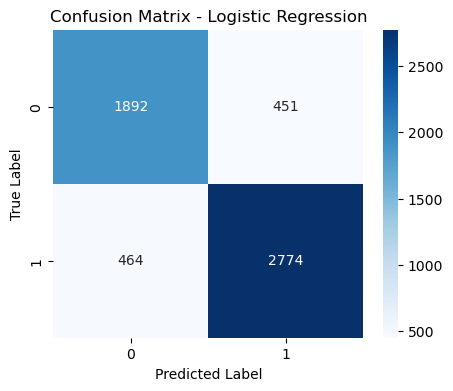

In [8]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_lr), 
    annot=True, 
    fmt='d', 
    cmap='Blues'
)

# Labeling for clarity
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [12]:
# ====================================================================
# 2. GENERATE DETAILED CLASSIFICATION REPORT (MACRO/WEIGHTED AVG)
# ====================================================================
print(f"\n\n--- DETAILED CLASSIFICATION REPORT FOR {model_name} ---")
from sklearn.metrics import classification_report

# 1. Generate the standard classification report text
report_dict = classification_report(
    y_test, 
    y_pred_lr, 
    target_names=['Class 0 (No Dep)', 'Class 1 (Dep)'], 
    output_dict=True
)

# 2. Convert the report dictionary into a clean Pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 3. Format scores to 4 decimal places for report display
report_df.iloc[:, 0:3] = report_df.iloc[:, 0:3].apply(lambda x: x.map('{:.4f}'.format))

# 4. Print the Markdown Table
print(report_df.to_markdown(numalign="left", stralign="left"))



--- DETAILED CLASSIFICATION REPORT FOR 1. Logistic Regression (LR) ---
|                  | precision   | recall   | f1-score   | support   |
|:-----------------|:------------|:---------|:-----------|:----------|
| Class 0 (No Dep) | 0.8031      | 0.8075   | 0.8053     | 2343      |
| Class 1 (Dep)    | 0.8602      | 0.8567   | 0.8584     | 3238      |
| accuracy         | 0.8361      | 0.8361   | 0.8361     | 0.836051  |
| macro avg        | 0.8316      | 0.8321   | 0.8319     | 5581      |
| weighted avg     | 0.8362      | 0.8361   | 0.8361     | 5581      |
